In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

# %matplotlib inline
plt.style.use("ggplot")
import plotly.graph_objects as go

import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

Adding the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=pd.read_csv("/content/drive/MyDrive/product recommendation/ratings_Electronics_subset.csv")
data.columns=['userName','productID','Rating','timestamp']

In [ ]:
data.head(5)

,userName,productID,Rating,timestamp
0,A2CX7LUOHB2NDG,321732944,5,1341100800
1,A2NWSAGRHCP8N5,439886341,1,1367193600
2,A2WNBOD3WNDNKT,439886341,3,1374451200
3,A1GI0U4ZRJA8WN,439886341,1,1334707200
4,A1QGNMC6O1VW39,511189877,5,1397433600


In [ ]:
data['productID'].nunique()

7236

In [ ]:
userID = pd.factorize(data['userName'])[0]

In [ ]:
userID

array([    0,     1,     2, ..., 93937, 93938, 93939])

In [ ]:
data['userID'] = userID

In [ ]:
data = data.dropna()
data.head()

,userName,productID,Rating,timestamp,userID
0,A2CX7LUOHB2NDG,321732944,5,1341100800,0
1,A2NWSAGRHCP8N5,439886341,1,1367193600,1
2,A2WNBOD3WNDNKT,439886341,3,1374451200,2
3,A1GI0U4ZRJA8WN,439886341,1,1334707200,3
4,A1QGNMC6O1VW39,511189877,5,1397433600,4


In [ ]:
data.shape

(104855, 5)

In [ ]:
# Calculate the frequency of ratings
rating_counts = data['Rating'].value_counts().sort_index()

# Create the bar chart using Plotly
fig = go.Figure(data=go.Bar(x=rating_counts.index, y=rating_counts.values))

# Customize the chart layout and style
fig.update_layout(
    title='Frequency of Ratings',
    xaxis_title='Rating',
    yaxis_title='Frequency',
    xaxis=dict(type='category'),
    yaxis=dict(type='linear'),
    plot_bgcolor='white',  # Set the background color
    bargap=0.2,  # Set the gap between bars
    bargroupgap=0.1,  # Set the gap between groups of bars
    font=dict(
        family='Arial',  # Set the font family
        size=14,  # Set the font size
        color='black'  # Set the font color
    )
)

# Display the chart
fig.show()

In [ ]:
# Calculate average rating for each product
product_ranking = data.groupby(['productID'])['Rating'].mean().reset_index().sort_values(by = 'Rating', ascending=False)
product_ranking

,productID,Rating
0,059400232X,5.0
4715,B00004Z5VO,5.0
4632,B00004Z5IC,5.0
4640,B00004Z5JS,5.0
1240,B00000J025,5.0
...,...,...
4777,B00004Z6DL,1.0
1027,9985699173,1.0
373,9876003313,1.0
4246,B00004XRD9,1.0


In [ ]:
# Create a distribution chart using Plotly
fig = go.Figure(data=[go.Histogram(x=product_ranking['Rating'], nbinsx=10)])

fig.update_layout(
    title="Average Rating Distribution",
    xaxis_title="Rating",
    yaxis_title="Count",
    bargap=0.1,
    bargroupgap=0.1
)

fig.update_traces(marker_color='rgba(50, 171, 96, 0.6)')

fig.show()

In [ ]:
# this pivot table is made to display the next graph
products_ratings = data.pivot_table(index='productID', columns='Rating', values='timestamp', aggfunc='count', fill_value=0)
products_ratings.columns = ['Rating ' + str(col) for col in products_ratings.columns]
products_ratings['Frequency'] = products_ratings.sum(axis=1)
# products_ratings = products_ratings.sort_values('Frequency', ascending=False)

In [ ]:
products_ratings

,Rating 1,Rating 2,Rating 3,Rating 4,Rating 5,Frequency
productID,,,,,,
059400232X,0,0,0,0,3,3
089933623X,1,0,0,1,0,2
094339676X,0,0,0,0,1,1
1034385789,0,1,0,0,4,5
1039869017,0,0,0,0,2,2
...,...,...,...,...,...,...
B00005MITH,0,0,1,2,1,4
B00005MITI,0,0,0,2,2,4
B00005MITJ,1,0,0,2,1,4


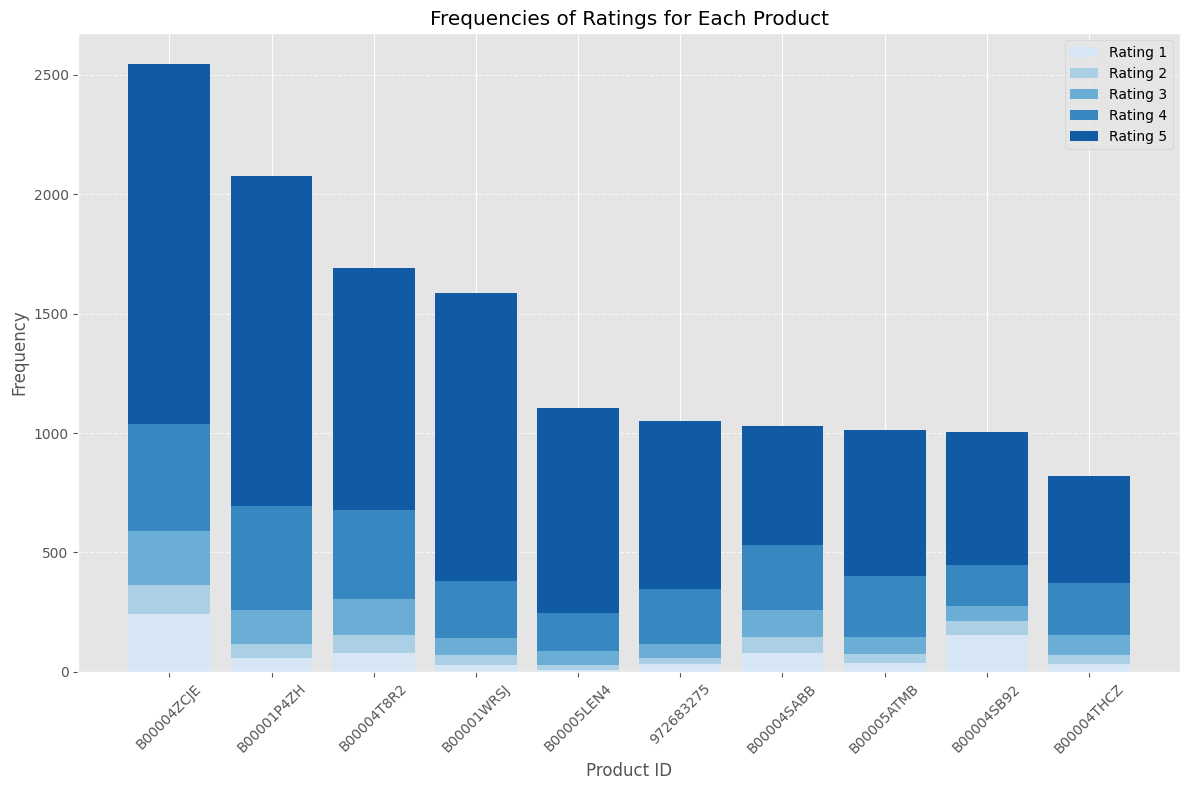

In [ ]:
# Extract data from the dataframe
df = products_ratings.sort_values('Frequency', ascending=False).head(10)

ratings = df[['Rating 1', 'Rating 2', 'Rating 3', 'Rating 4', 'Rating 5']].values
product_ids = df.index.values

# Define a blue color palette
colors = sns.color_palette('Blues', n_colors=5)

# Plot the bar chart with a white background
plt.figure(figsize=(12, 8), facecolor='w')
for i in range(5):
    plt.bar(product_ids, ratings[:, i], bottom=ratings[:, :i].sum(axis=1), color=colors[i], label='Rating ' + str(i+1))

# Customize the plot
plt.xlabel('Product ID')
plt.ylabel('Frequency')
plt.title('Frequencies of Ratings for Each Product')
plt.legend(loc='upper right')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()

## Now recommendation

This is the main function

In [ ]:
def recommend_products(user_id, user_similarity, user_item_matrix):
    # Get the products that the user has not rated yet.
    unrated_products = user_item_matrix.loc[user_id, :].isna()
    unrated_products = unrated_products.index.values

    # Get the top-k similar users.
    k = 5
    similar_users = user_similarity[user_id].argsort()[-k:][::-1]

    # Get the ratings of the unrated products by the similar users.
    similar_user_ratings = user_item_matrix.loc[similar_users, unrated_products]

    # Calculate the weighted average of the ratings.
    recommended_ratings = similar_user_ratings.mean(axis=0)

    # Sort the recommended ratings by descending order.
    recommended_ratings = np.array(recommended_ratings).argsort()[::-1]

    # Return the top-k recommended products.
    return unrated_products[recommended_ratings[:k]]

In [ ]:
data1= data.head(10000)
data1 = data1.sort_values(by = 'userID', ascending = True)

In [ ]:
data1.head(5)

,userName,productID,Rating,timestamp,userID
0,A2CX7LUOHB2NDG,321732944,5,1341100800,0
1,A2NWSAGRHCP8N5,439886341,1,1367193600,1
2,A2WNBOD3WNDNKT,439886341,3,1374451200,2
3,A1GI0U4ZRJA8WN,439886341,1,1334707200,3
4,A1QGNMC6O1VW39,511189877,5,1397433600,4


In [ ]:
data1['productID'].nunique()

1304

In [ ]:
ratings_utility_matrix = data1.pivot_table(index='userID', columns='productID', values='Rating', fill_value=0)
ratings_utility_matrix

productID,059400232X,089933623X,094339676X,1034385789,1039869017,1085901386,1094441252,1182702627,1254875778,134048160X,...,B00000J1DN,B00000J1DT,B00000J1E6,B00000J1EC,B00000J1EJ,B00000J1EP,B00000J1EQ,B00000J1ES,B00000J1EZ,B00000J1F3
userID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9821,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
9822,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
9823,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [ ]:
ratings_utility_matrix.shape

(9826, 1304)

In [ ]:
user_similarity = cosine_similarity(ratings_utility_matrix)

In [ ]:
# Get the user ID of the user you want to recommend products to.
#user_id = data1['userID'].value_counts().idxmax()

# Recommend products to the user.
recommended_products = recommend_products(int(1000), user_similarity, ratings_utility_matrix)

# Print the recommended products.
print(recommended_products)

['972683275' 'B00000J1F3' '9966285962' '9966283536' '9966284699']


In [ ]:
for i in data1['userID']:
  recommended_products = recommend_products(int(i), user_similarity, ratings_utility_matrix)
  # Print the recommended products.

  print("for user: ", i, "recommended products are: ", recommended_products)


for user:  0 recommended products are:  ['1400698987' '321732944' 'B00000J1F3' '996628642X' '9966284699']
for user:  1 recommended products are:  ['439886341' 'B00000J1F3' '1400698987' '9966285962' '9966284699']
for user:  2 recommended products are:  ['439886341' 'B00000J1F3' '1400698987' '9966285962' '9966284699']
for user:  3 recommended products are:  ['439886341' 'B00000J1F3' '1400698987' '9966285962' '9966284699']
for user:  4 recommended products are:  ['511189877' 'B00000J1F3' '9966289291' '9966284699' '9966284826']
for user:  5 recommended products are:  ['511189877' 'B00000J1F3' '9966289291' '9966284699' '9966284826']
for user:  6 recommended products are:  ['511189877' 'B00000J1F3' '9966289291' '9966284699' '9966284826']
for user:  7 recommended products are:  ['511189877' 'B00000J1F3' '9966289291' '9966284699' '9966284826']
for user:  8 recommended products are:  ['511189877' 'B00000J1F3' '9966289291' '9966284699' '9966284826']
for user:  9 recommended products are:  ['5111

KeyboardInterrupt: ignored

In [ ]:
for index, row in data1.iterrows():
    user_id = int(row['userID'])
    recommended_products = recommend_products(user_id, user_similarity, ratings_utility_matrix)
    # Print the recommended products along with the corresponding username.
    print("For user:", row['userName'], "(UserID:", user_id, ") recommended products are:", recommended_products)
